In [1]:
import h5py
import pickle
import folium
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [144]:
with h5py.File('data/sensor_graph/pems-bay.h5', 'r') as file:

    axis0 = file['speed']['axis0'][:]               # Идентификаторы датчиков
    block0_items = file['speed']['block0_items'][:] # Идентификаторы датчиков
    axis1 = file['speed']['axis1'][:]               # Метки времени
    timestamps = pd.to_datetime(axis1)              # Преобразование меток времени в формат datetime
    speed_data = file['speed']['block0_values'][:]  # Данные замеров скорости

perms_bay = pd.DataFrame(speed_data, index=timestamps, columns=axis0)


In [2]:
# Открытие .pkl файла
with open('data/sensor_graph/adj_mx_bay.pkl', 'rb') as file:
    data = pickle.load(file, encoding='bytes')

In [3]:
node_ids = [x.decode('utf-8') for x in data[0]]                     # Получаем список id узлов из data[0]
adj_matrix = data[2]                                                # Получаем матрицу смежности из data[2]
adj_df = pd.DataFrame(adj_matrix, index=node_ids, columns=node_ids) # Создание DataFrame с использованием id узлов как индексов и названий колонок

In [4]:
distances_df = pd.read_csv('data/sensor_graph/distances_bay_2017.csv', header=None)
locations_df = pd.read_csv('data/sensor_graph/graph_sensor_locations_bay.csv', header=None)

In [5]:
# Создание графа
G = nx.Graph()

# Добавление узлов с координатами
for _, row in locations_df.iterrows():
    node_id = row[0]
    x, y = row[1], row[2]
    G.add_node(str(int(node_id)), pos=(x, y))

# Добавление рёбер на основе матрицы смежности
for node1 in adj_df.index:
    for node2 in adj_df.columns:
        weight = adj_df.loc[node1, node2]
        if weight != 0 and node1 != node2:  # Добавляем ребро только если вес не равен 0
            G.add_edge(node1, node2, weight=weight)

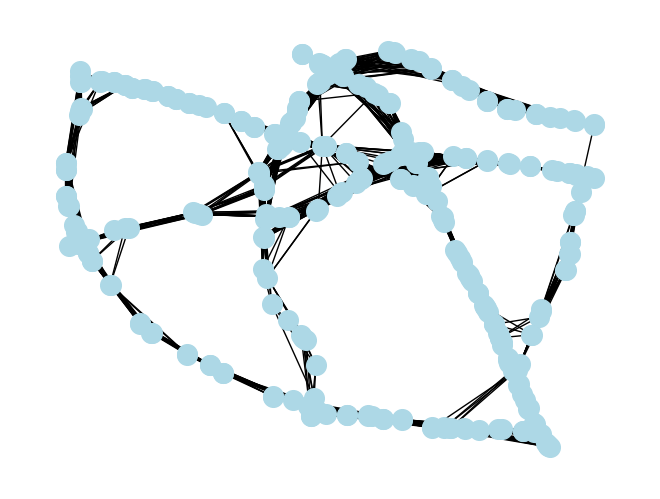

In [6]:
# Визуализация графа с использованием координат

pos = nx.get_node_attributes(G, 'pos')  # получаем координаты
nx.draw(G, pos, with_labels=False, node_size=200, node_color='lightblue', font_size=8)
plt.show()

In [7]:
# Создаем карту Folium, центрируем её на одном из узлов
m = folium.Map(location=[37.359087, -121.906538], zoom_start=13)

# Добавляем узлы на карту
for node, data in G.nodes(data=True):
    folium.Circle(location=[data['pos'][0], data['pos'][1]], popup=str(node)).add_to(m)

# Добавляем рёбра на карту
for edge in G.edges(data=True):
    node1 = edge[0]
    node2 = edge[1]
    
    # Координаты двух узлов
    loc1 = G.nodes[node1]['pos']
    loc2 = G.nodes[node2]['pos']
    
    # Рисуем линию между узлами
    folium.PolyLine(locations=[(loc1[0], loc1[1]), (loc2[0], loc2[1])], color='blue', weight=2.5).add_to(m)

# Отображаем карту
# m.save('graph_map.html')
m